# Práctica 2: Aprendizaje automático

El objetivo de esta práctica es aplicar los distintos algoritmos de aprendizaje automático disponibles en la scikit-learn [sklearn](https://scikit-learn.org/stable/) sobre varios conjuntos de datos y aprender a interpretar los resultados obtenidos. La práctica consta de __2 notebooks__ que se entregarán en las tareas de entrega habilitadas en el Campus Virtual. Este notebook corresponde al apartado de __clustering__.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

__Número de grupo: J__

__Nombres de los estudiantes: Diego Martínez López y Damián Benasco Sánchez__

# Apartado 1: Clustering

## 1) Carga del conjunto de datos

Crea un dataframe a partir del fichero `prestamos.csv` que se proporciona junto con la práctica.

El conjunto de datos contiene por cada fila los datos de un préstamo que fue concedido por una empresa de crédito p2p. Las variables que caracterizan el préstamo son las siguientes:
  - `loan_amnt` es la cantidad de dinero solicitada en dólares
  - `purpose` es el propósito para el que se solicitó el préstamo
  - `revenue` son los ingresos anuales en dólares de la persona que solicitó el préstamos
  - `dti_n` es el porcentaje de endeudamiento sobre los ingresos anuales de la persona que solicitó el préstamo
  - `fico_n` se trata de un indicador de solvencia de la persona que solicitó el préstamo. A mayor puntuación, mayor solvencia, y además se cuenta con estos rangos orientativoss:
    - 300-550: Pobre
    - 550-620: Subprime (alto riesgo)
    - 620-680: Crédito aceptable
    - 680-740: Buen crédito
    - 740-850: Excelente crédito

  -`home_ownership_n` es una variable categórica que indica la situación de vivienda en la que vive la persona solicitante
    - `OWN` es en propiedad
    - `MORTAGAGE` indica que está hipotecada
    - `RENT` indica que vive en alquiler
    - `OTHER` es una categoría que agrega otras posibilidades

- `emp_length` es una variable ordinal, no es estrictamente numérica, ya que el valor 0 denota que no consta información, los valores entre 1 y 10 indican una permanencia inferior a X años, y el valor 11 indica una permanencia superior a 10 años.
- `Default` es la variable que usaremos como **variable objetivo** del conjunto de datos e indica si la persona incumplió (incurrió en *default*) o no el préstamo.


Como pandas no tiene forma de saber que las variables `home_ownership_n`, `emp_length` y `Default` son en realidad categóricas, debes indicárselo tú.

En primer lugar, cargamos el dataframe en una variable llamada df_csv, e indicamos explícitamente que las variables home_ownership_n, emp_length_n y Default son variables categóricas.

Además importamos todas las librerías que necesitaremos ahora y más adelante.

In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.datasets import make_blobs
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [9]:
df_csv = pd.read_csv('prestamos.csv', dtype={
        'home_ownership_n': 'category',
        'emp_length_n': 'category',  # o 'emp_length_n' si tu CSV tiene esta cabecera
        'Default': 'category'
    })
df_csv

,loan_amnt,purpose,revenue,dti_n,fico_n,home_ownership_n,emp_length_n,Default
0,32000,car,135000.0,18.93,687.0,MORTGAGE,1,0
1,32000,car,90000.0,9.29,822.0,MORTGAGE,10,1
2,30000,car,95000.0,1.34,722.0,RENT,11,0
3,25750,car,230000.0,6.42,747.0,MORTGAGE,11,0
4,25200,car,72000.0,30.95,692.0,OWN,11,0
...,...,...,...,...,...,...,...,...
13789,1275,vacation,42000.0,31.89,792.0,RENT,0,0
13790,1200,vacation,36000.0,12.27,747.0,MORTGAGE,8,0
13791,1000,vacation,76000.0,25.26,702.0,MORTGAGE,11,0
13792,1000,vacation,32000.0,17.70,747.0,MORTGAGE,0,0


## 2) Análisis de los datos

### 2.1) Numéricos

Analiza razonadamente las distribuciones de cada una de las variables numéricas (medias, desviaciones típicas, rangos, ...) y las principales relaciones entre pares de variables (diagrama de dispersión, coeficientes de correlación, ...).

En primer lugar, vamos a extraer los datos estadísticos de cada una de las variables numéricas, como pueden ser la media, la desviación típica o los rangos. Para ello, utilizamos la función de pandas describe, y seleccionamos únicamente las variables numéricas.

In [10]:
df_csv.describe(include='number').transpose()

,count,mean,std,min,25%,50%,75%,max
loan_amnt,13794.0,14507.833116,9037.938271,1000.0,7300.0,12000.000,20000.0000,40000.00
revenue,13794.0,79737.299507,56463.579892,7000.0,48000.0,68000.000,97000.0000,1650000.00
dti_n,13794.0,18.825106,9.795986,0.0,12.2,18.085,24.7575,190.87
fico_n,13794.0,699.106822,32.825754,662.0,672.0,692.000,717.0000,847.50


A continuación vamos a realizar dos procesos. En primer lugar vamos a generar histogramas y a analizar cada una de las variables por separado, para posteriormente terminar analizando pares de variables y la correlación entre ellas.

Procedemos a generar los histogramas para cada una de las variables:

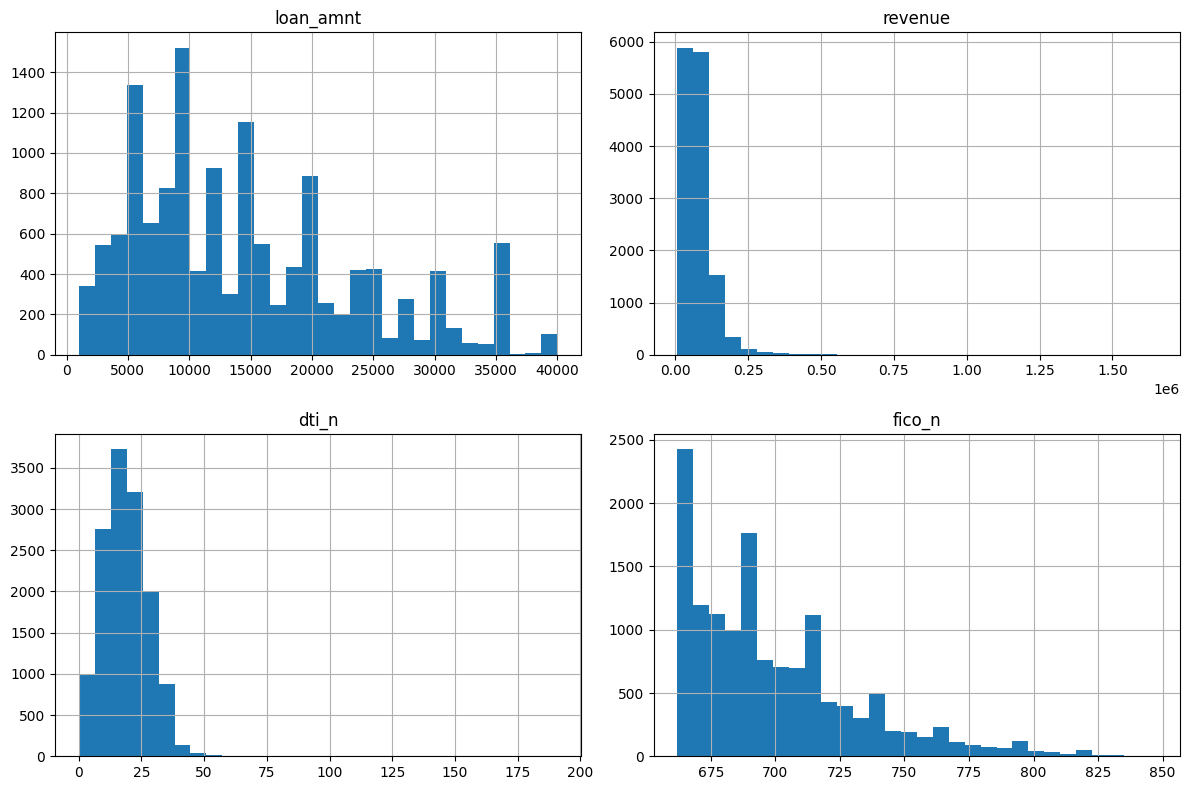

In [11]:
df_csv.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

Antes de analizar cada estadístico de cada variable, vamos a comentar un poco los histogramas generados arriba. Para cada histograma, el eje x muestra los rangos de valores que toma la variable que se está representando en él, y el eje y muestra la frecuencia o número de observaciones  que caen dentro de cada rango.
En primer lugar, podemos observar que en el hitograma del loan_amnt, que es la cantidad de dinero pedido como préstamo, el grueso de datos están en torno a 10000 dólares. Es decir, del total de préstamos, la mayor parte de la población ha solicitado un préstamos de 10 mil dólares. Además, se observan unos pocos datos extremos, de una cantidad elevada de préstamo, lo cual como veremos más adelante, tiene relevancia en los estadísticos de esta variable.
Por otro lado en cuanto a la revenue, que representa los ingresos anuales, podemos ver que la mayor parte de la población tiene unos ingresos de entre 20000 y 100000 dólares, habiendo pocos individuos con unos ingresos mayores a 100000 dólares. Esto tendrá reflejo en la media de esta variable, además de en la mediana que se situarán en torno a estos valores.
Además en el histograma del dti_n, que representa el endeudamiento, podemos ver que la mayor parte de la población tiene un endeudamiento del 20 por ciento sobre el total de sus ingresos, que no es una cantidad muy elevada, aunque hay unos pocos individuos con un soobreendeudamiento. 
Por último, en el histograma del fico_n, que representa la solvencia de cada uno de los individuos que pidieron un préstamos, podemos ver que el grueso de ellos está en 650 puntos y al avanzar se va reduciendo el número de individuos con esa puntuación. Esto refleja que en general la gente tiene un crédito aceptable, aunque algún individuo podría aproximarse a un crédito con riesgo.

Tras extraer esta información de los histogramas, vamos a interpretar los estadísticos de cada una de las variables, que nos darán más información a cerca de los datos que poseemos.

Loan_amnt (dinero prestado): podemos observar que la mayoría de los préstamos se sitúan entre 7.300 y 20.000 USD, con un valor máximo de 40.000 USD, confirmando las conclusiones obtenidas directamente a partir del hitograma.Además, la mediana (12.000) es bastante inferior al máximo, lo que sugiere una distribución algo sesgada a la derecha, es decir, hay menos préstamos en cantidades muy altas, pero estos pocos valores altos empujan la media hacia arriba. Esto es debido a que la media es un estadístico muy sensible a valores extremos, por lo que un dato elevado de crédito tiene un gran efecto sobre la misma.
Además, El valor mínimo de 1.000 USD puede representar micropréstamos, pero aunque 1000 es el valor más pequeño, hay pocos datos detal cantidad.
Por último, el rango (max-min) es de 39.000, lo cual, junto con la desviación típica (~9.038), indica una variabilidad importante en las cantidades solicitadas.

Revenue (ingresos anuales): Hay mucha dispersión en los ingresos pues el std, que es la desviación típica, es de aproximadamente 56 mil dólares. El intervalo intercuartílico va desde 48k a 97k, pero el máximo asciende hasta 1,65 millones. Esto indica una distribución muy asimétrica  con un grupo pequeño de usuarios de ingresos muy altos. Es esperable que, en términos de correlación, los ingresos tengan cierta relación con el importe del préstamo solicitado o con otros factores de solvencia, lo cual verificaremos a continuación con el análisis bivariante.
Asimismo, aquí la media (79.737) también es superior a la mediana (68.000), lo que indica igualmente una asimetría a la derecha; hay menos personas con ingresos muy elevados, pero estos ingresos extremos (por encima de 1 millón de USD) aumentan considerablemente la media.
El IQR va de 48.000 a 97.000 USD, lo que sugiere que la mitad de los clientes gana entre 48k dólares al año y 97k dólares al año. 
Por último, cabe destacar, que el valor máximo al ser muy elevado, y dado que la mayoría de la población gana menos de 100k dólares anuales, es probable que existan unos pocos casos muy atípicos en la distribución de ingresos.

Dti_n (porcentaje de endeudamiento): podemos observar que la mayoría de los valores se concentra entre 12% y 25%, como vimos anteriormente en el histograma, lo cual es un endeudamento razonable. Sin embargo, hay casos extremos (endeudamiento muy alto, superior al 100%), lo cual puede indicar situaciones financieras de elevado riesgo. Estos valores tan altos (hasta 190,87%) podrían responder a clientes con deudas muy elevadas o con errores en la declaración de ingresos. Es importante resaltar que para el clustering puede que sea conveniente caparlos, transformarlos (por ejemplo, con transformación logarítmica) o tratarlos como outliers.
Asimismo, el valor mínimo 0% podría implicar casos en los que oficialmente no se observa deuda previa o se registran ingresos muy altos respecto a la deuda total, por lo que el endeudamiento es despreciable.
Por último, cabe destacar que el hecho de que la mediana (18,09%) sea muy cercana a la media (18,83%) sugiere que, salvo por unos pocos valores muy elevados, la mayoría de la distribución se concentra alrededor de ese 18–19%, es decir a diferencia de los dos casos anteriores, no tenemos casos atípicos tan extremos que empujen la distribución hacia la derecha. 




Fico_n (indicador de solvencia): observamos que aunque el rango de FICO (teóricamente) va de 300 a 850, en este conjunto los valores se concentran entre 662 y 847. Vemos que los cuartiles se sitúan en 672 y 717, lo que sugiere que la mayor parte de los solicitantes está por encima de 660, es decir, en la parte media o alta del rango de credit scores. La distribución no se extiende a puntajes muy bajos (por debajo de 660), por lo que podría haber cierto sesgo de selección, es decir, sería conveniente obtener más datos de personas con menor solvencia para evitar el sesgo en el posterior entrenamiento del modelo. Además, por esto podemos deducir que el conjunto de préstamos puede provenir de un subset de clientes que ya cumplían un mínimo de solvencia.
Por otro lado, la mediana (692) está algo por debajo de la media (699), nuevamente apuntando a cierta asimetría a la derecha, aunque no muy acusada, y la desviación típica (32,83) indica un rango de variación moderado.
Por último, dado que el FICO es una variable muy importante para el riesgo crediticio, sería interesante correlacionarla con Default (si está disponible) y con la antigüedad en el empleo.


Procedemos ahora a hacer un análisis entre pares de variables, para ver cuales están correlacionadas y de qué manera. Para ello, procedemos mediante el análisis bivariante, que analiza presisamente el grado de relación entre pares de variables.

### Análisis bivariante

#### Matriz de correlación

Recordemos que la matriz de correlación es una matriz donde la posición (i,j) almacena el grado de correlación o índice de Pearson entre las variables i y j. Recordemos que este varía de -1 a 1, y qye valores negativos representan una correlación negativa (cuando i aumenta j disminuye y viceversa) mientras que valores positivos representa una correlación positiva (si i aumenta j también aumenta), mientras que valores cercanos a 0 indican una correlación baja o nula.

In [12]:
corr_matrix = df_csv.select_dtypes(include='number').corr()
print(corr_matrix)

           loan_amnt   revenue     dti_n    fico_n
loan_amnt   1.000000  0.424460  0.034134  0.090869
revenue     0.424460  1.000000 -0.137616  0.091204
dti_n       0.034134 -0.137616  1.000000 -0.057580
fico_n      0.090869  0.091204 -0.057580  1.000000


Podemos observar en la matriz de correlación que el par de variables que tienen una mayor relación son la cantidad de dinero prestado con los ingresos anuales, que tienen un índice de Pearson de 0,42. Por tanto, como están positivamente relacionadas, a mayor crédito mayores serán los ingresos anuales (y viceversa), y a menor crédito menores ingresos anuales (y viceversa).
Por otro lado, también podemos observar una leve correlación entre los ingresos anuales y el índice de endeudamiento, con un índice de -0,14. Como este es negativo, a mayores ingresos menor porcentaje de endeudamiento (y viceversa), y a mayores ingresos menor el porcentaje de endeudamiento (y viceversa).
Esto refleja que, aunque cuanto mayores sean los ingresos de una persona, mayor es el crédito que solicita, los ingresos son mayores al aumento en la cantidad del préstamo.
Por último, cabe destacar que el resto de índices son muy próximos a cero, por lo que reflejan una correlación muy baja entre el resto de pares de variables.
Resumiendo, el par más correlacionado es loan_amnt vs. revenue, revenue vs. dti_n tiene una relación negativa, aunque no muy marcada y el resto de correlaciones son muy bajas, por lo que las asociaciones lineales entre esas variables son débiles o inexistentes.

#### Diagramas de dispersión

Procedemos ahora a graficar los diagramas de dispersión entre pares de variables, para posteriormente analizar los resultados obtenidos, que veremos que reflejarán la misma información que la descrita en la matriz de correlación.

In [13]:
dic_colors = {
    'MORTGAGE': 'green',
    'RENT': 'red',
    'OWN': 'blue',
    'OTHER': 'orange'
}

# Mapeo temporal para la visualización
colors = df_csv['home_ownership_n'].map(dic_colors)

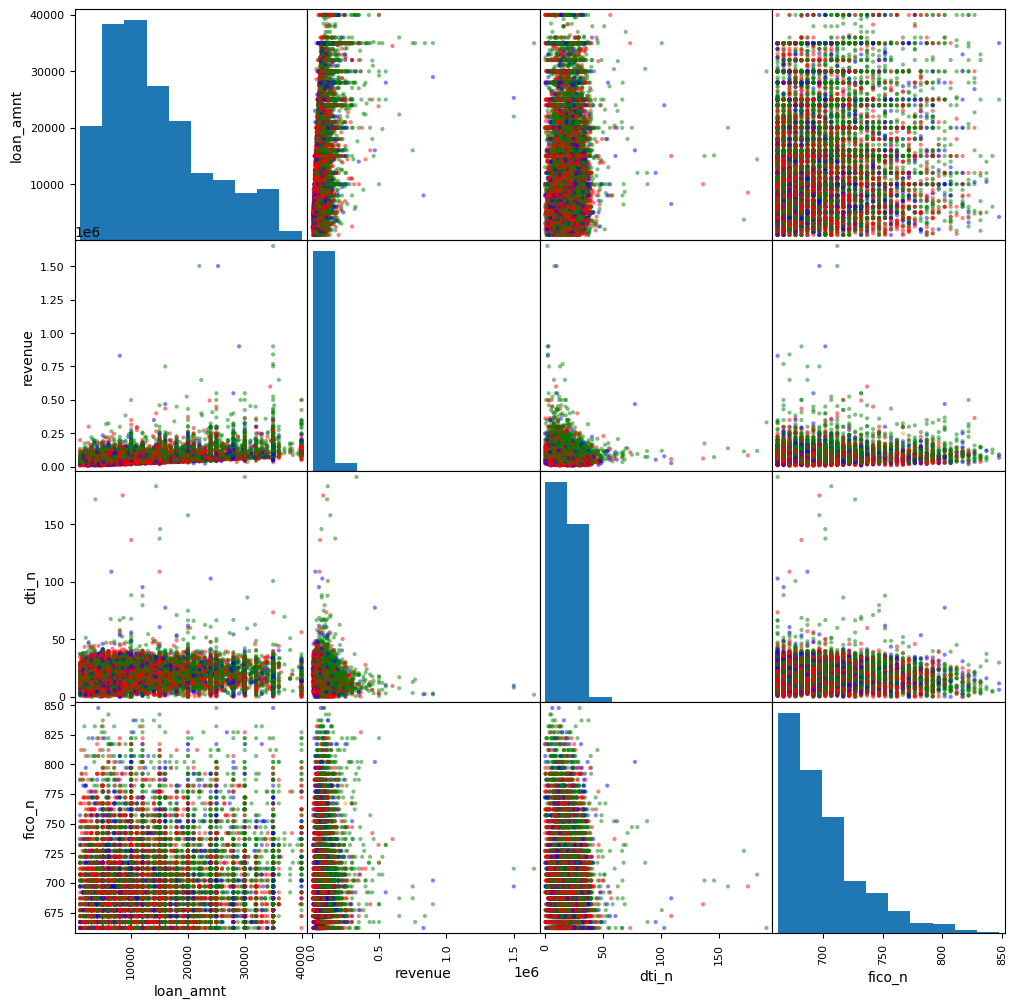

In [14]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

numeric_cols = ['loan_amnt', 'revenue', 'dti_n', 'fico_n']

scatter_matrix(
    df_csv[numeric_cols],
    figsize=(12, 12),
    diagonal='hist',
    c=colors  # Importante usar 'c=colors'
)
plt.show()

In [15]:
colors

0        green
1        green
2          red
3        green
4         blue
         ...  
13789      red
13790    green
13791    green
13792    green
13793    green
Name: home_ownership_n, Length: 13794, dtype: category
Categories (4, object): ['green', 'orange', 'blue', 'red']

Observamos que hemos graficado la matriz de gráficas, donde en la diagonal se han graficado los histogramas de cada variable, que ya lo hemos comentado anteriormente, y en el resto de posiciones los diagramas de dispersión de cada par de variables. Como ya hemos analizado los histogramas, procedemos a analizar los diagramas de dispersión de pares de variables. Además cabe destacar que hemos coloreado cada individuo en color en función al home_ownership, para ver si, aunque esta sea una variable categórica, podemos ir sacando alguna conclusión extra para el siguiente apartado.


Par loan_amnt/revenue: recordemos que el histograma nos decía que este par era el que más correlacionado (positivamente) estaba. Esto se ve reflejado en el diagrama de dispersión, pues observamos que al ir aumentando el loan_amnt aumenta la cantidad de ingresos anuales. Además podemos ver reflejado que para préstamos pequeños el los ingresos anuales son bastante más reducidos, y que la mayor parte de los individuos tienen pares de ingresos y créditos moderados. 
Además en cuanto al home_ownership, podemos ver que la mayor parte de la población con crédito moderado e ingresos moderados son de color rojo, lo que indica que están de alquiler, mientras que al ir aumentando los ingresos y el crédito se agrupan más individuos de color verde (hipotecados) y de color azul (con casa en propiedad). Esto muestra que los individuos con un mayor poder adquisitivo piden créditos más elevados e invierten con mayor probabilidad en inmuebles

Par revenue/dti_n: podemos observar que el diagrama de dispersión refleja de nuevo las conclusiones de la matriz de correlación. Así, vemos que a mayores ingresos menor es el porcentaje de endeudamiento de los individuos. Además podemos ver reflejado que la mayoría de individuos tiene un ingreso moderado, pero hay varios con un porcentaje de endeudamiento elevado. Esto se debe a que, como habíamos visto, como el índice de Pearson es negativo, a menores ingresos, mayor es el índice de endeudamiento. Esto se ve con los puntos concentrados en la esquina inferior izquierda del diagrama de dispersión, evidenciando de nuevo individuos con ingresos reducidos y un porcentaje de endeudamiento un poco elevado.
Por último, en cuanto a los colores de los individuos, vemos que todos los que están de alquiler o hipotecados tienen unos ingresos más bien moderados e índices de endeudamiento un poco mayores, mientras que los propietarios tienen ingresos elevados y bajos niveles de endeudamiento

Resto de pares: podemos observar que, como habíamos concluido con la matriz de correlación, el resto de diagrama de fases de pares de variables no muestran ninguna información significativa, pues como habíamos visto, el resto de pares de variables tenían un índice de correlación cercano a cero, por lo que no estaban prácticamente relacionadas.


### 2.2) Categóricos

Analiza razonadamente las distribuciones de los valores de las variables categóricas incluyendo un diagrama de frecuencias y comentando lo más destacable.

Procedemos ahora a analizar las distribuciones de los valores de las variables categóricas,y para ello vamos a incluir un diagrama de frecuencias y vamos a analizar el mismo para obtener conclusiones sobre las variables.


Distribución de la variable 'home_ownership_n':
home_ownership_n
MORTGAGE    6850
RENT        5349
OWN         1586
OTHER          9
Name: count, dtype: int64


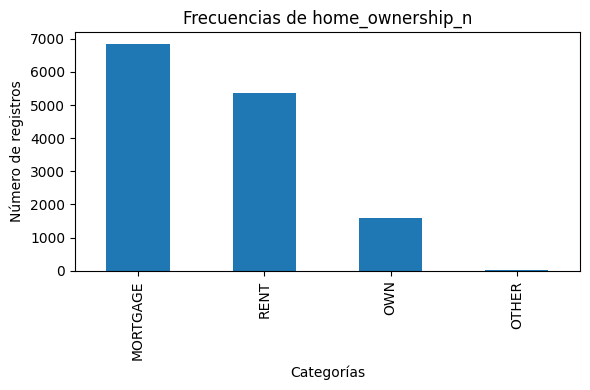


Distribución de la variable 'emp_length_n':
emp_length_n
11    4612
3     1232
1     1174
4     1174
2      909
0      875
6      860
5      815
9      599
7      580
10     494
8      470
Name: count, dtype: int64


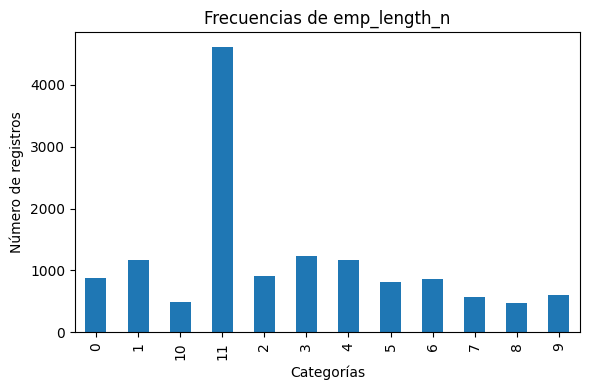


Distribución de la variable 'Default':
Default
0    10785
1     3009
Name: count, dtype: int64


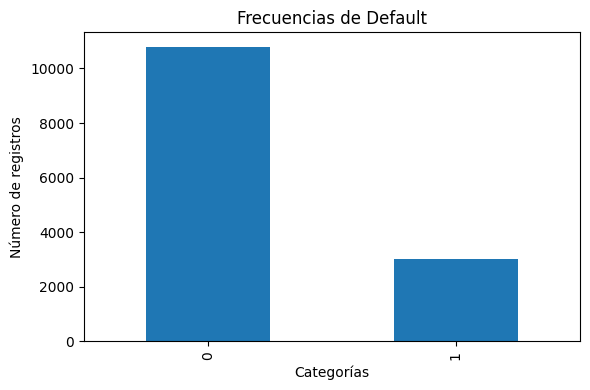

In [16]:
import matplotlib.pyplot as plt

# Definimos las columnas categóricas
categorical_cols =['home_ownership_n','emp_length_n', 'Default']

# Recorremos cada columna categórica para:
# 1) Mostrar la distribución de valores en la consola
# 2) Dibujar un gráfico de barras con la frecuencia de cada categoría
for col in categorical_cols:
    print(f"\nDistribución de la variable '{col}':")
    print(df_csv[col].value_counts(dropna=False))
    
    # Para variables puramente categóricas sin orden, basta con plot.bar()
    # En el caso de 'emp_length_n' (que es ordinal), podríamos querer .sort_index()
    # si los valores son 0,1,2,...,11. Ajusta según necesites.

    if col == 'emp_length_n':
        # Ordenamos por índice si te interesa que aparezcan en orden 0,1,2,...,11
        df_csv[col].value_counts(dropna=False).sort_index().plot.bar(figsize=(6,4))
    else:
        df_csv[col].value_counts(dropna=False).plot.bar(figsize=(6,4))
    
    plt.title(f"Frecuencias de {col}")
    plt.xlabel("Categorías")
    plt.ylabel("Número de registros")
    plt.tight_layout()
    plt.show()


A partir de los diagramas de frecuencias (histogramas) vamos a analizar cada una de las variables categóricas.

Home_ownership_n (situación de vivienda): observamos que la gran parte de la población vive hipotecado, lo cual puede coincidir con que pidan créditos. Posteriormente vemos que el siguiente grupo (el 40% aproximadamente) es el de la gente que vive de alquiler, que recordemos que en el estudio anterior se correspondía en mayor cantidad con ingresos anuales bajos. Por último tenemos los grupos de población que poseen casas en propiedad, que es bastante reducido (enn torno a un 11%), y como habíamos visto se correspondía con población con rentas elevadas, y el grupo other, que vemos que es prácticamente despreciable, pues el número de personas qe se enmarcan en este grupo es ínfimo.

Emp_length_n (permanencia en trabajo): la categoría “11” (más de 10 años de antigüedad) es la más numerosa (4.612 registros), mientras que el resto de categorías se reparten en torno a 1–10 años de antigüedad, con valores entre ~500 y ~1.200 registros cada una. Por otro lado, la categoría “0” (no consta información) también aparece 875 veces, lo cual no es despreciable.
Que el valor “11” sea tan frecuente puede indicar que un gran porcentaje de solicitantes tiene más de 10 años en la misma empresa o simplemente lleva lo suficiente en el mercado laboral como para clasificarse en ese grupo.
Hay una distribución razonablemente amplia entre 1–10 años, con una presencia significativa de quienes llevan 3 o 4 años, y 1 año también sobresale.
Un 875 de los registros no tienen información de antigüedad laboral (0), lo que puede complicar un análisis de riesgo (falta de dato).
En un análisis posterior, sería interesante ver cómo se relacionan estas categorías con la variable Default (si la estabilidad laboral influye en la morosidad).


Default (incumplimiento de préstamo) : recordemos que es la variable objetivo, que indica con 1 si se incumplió el préstamos y con 0 si no se incumplió.
No incumple (0): 10.785 registros (78% del total)
Incumple (1): 3.009 registros (22% del total)
Aproximadamente un 22% de los préstamos han terminado en incumplimiento (default), mientras que un 78% no.
Esta distribución indica que el dataset no está extremadamente desbalanceado (no es un 95% vs. 5%), pero sí muestra una diferencia clara: hay más gente que cumple que la que incumple.
De cara a un modelo predictivo o un análisis de riesgo, conviene tener en cuenta este 22% como tasa de default.

Conclusiones generales
Situación de vivienda (home_ownership_n)

Mayores grupos: MORTGAGE (hipoteca) y RENT (alquiler). Propietarios absolutos (OWN) son una minoría (aunque no despreciable).
“OTHER” es casi anecdótico.
Antigüedad en el empleo (emp_length_n)

Un cuarto del conjunto tiene más de 10 años de antigüedad (categoría 11).
El resto se reparte entre 1–10 años y un 6–7% no aporta dato (0).
Incumplimiento (Default)

~22% de los solicitantes incurrió en default, y ~78% no lo hizo.
Permite un análisis interesante sobre qué factores (p.ej., la antigüedad laboral, el tipo de vivienda, etc.) se asocian con un mayor o menor riesgo de incumplimiento.


## 3) Preprocesar los datos

Para el clustering vamos a trabajar solamente con las variables verdaderamente numéricas. Crea un nuevo dataframe que sólo contenga las variables `loan_amnt`, `revenue`, `dti_n` y `fico_n`.

Teniendo en cuenta que vamos a utilizar el algoritmo k-Means para encontrar grupos de préstamos similares, explica razonadamente si es necesario o no cambiar la escalas de los datos y si a priori es mejor reescalarlos (MinMaxScaler) o estandarizarlos (StandarScaler).

Si decides preprocesarlos, accede al array interno del dataframe y crea un nuevo array con los datos escalados.

Primero, creamos un nuevo dataframe que solo contenga las variables loan_amnt, revenue, dti_n y fico_n, como se nos pide en el enunciado.

In [17]:
df_numeral = df_csv[['loan_amnt', 'revenue', 'dti_n', 'fico_n']]
df_numeral

,loan_amnt,revenue,dti_n,fico_n
0,32000,135000.0,18.93,687.0
1,32000,90000.0,9.29,822.0
2,30000,95000.0,1.34,722.0
3,25750,230000.0,6.42,747.0
4,25200,72000.0,30.95,692.0
...,...,...,...,...
13789,1275,42000.0,31.89,792.0
13790,1200,36000.0,12.27,747.0
13791,1000,76000.0,25.26,702.0
13792,1000,32000.0,17.70,747.0


A la hora de aplicar k-Means, el uso de distancias euclídeas hace imprescindible que todas las variables numéricas que intervienen en el clustering estén en una escala comparable. De lo contrario, las diferencias en una variable con un rango mayor dominarían el cálculo de distancias, y se formaría la agrupación con base en esa variable, eclipsando el aporte de las demás.
Recordemos que el algoritmo de k-Means, dado el valor de k inicializa k centros de los clusters de forma aleatoria, para luego ir asignando a cada punto la pertenencia a un cluster que esté más cercano, actualizando posteriormente el centro de los clusters y repitiendo este proceso hasta que la actualización de los centros de los clusters no varíen.
Además, cabe destacar que la distancia más comunmente utilizada en el K-Means es la distancia euclídea. Si observamos las 4 variables, vemos que el loan_amnt toma valores de 1000 a 40000, el revenue de 7000 a 1650000, el dt_n de 0 a 18 y el fico_n de 660 a 850. Por tanto, revenue tiene un rango muy amplio mientras que loan_amnt, aunque es menor que revenue, puede alcanzar 40.000, que sigue siendo bastante superior al rango de fico_n o dti_n.
Por otra parte, dti_n y fico_n quedan en escalas más pequeñas comparadas con revenue o incluso loan_amnt.
Por lo tanto, para evitar que la variable con mayor rango (especialmente revenue, pero también loan_amnt) “pese” mucho más en la distancia euclídea, se deberíamos reescalar (o estandarizar) las cuatro variables antes de aplicar k-Means, para que así al calcular la distancia euclídea no pesen más unas variables que otras. 
Para ello, debemos decir si es mejor reescalar o estandarizar. Recordemos que MinMaxScaler escala linealmente cada variable para que sus valores queden típicamente en el intervalo [0,1]. Además tiene la ventaja de que se iterpreta fácil y que comprime los datos en un rango fijo, pero como desventaja tiene que (al igual que sucedía con la media) es muy sensible a valores extremos, por lo que si tenemos un valor muy alto de alguna variable, como ocurría en el revenue, va a arrastar al resto de valores que se comprimirán muy cerca del 0. Es por ello que, como tenemos valores extremos, no vamos a elegir reescalar los datos, sino que vamos a aplicar el StandarScaler, que explicaremos a continuación.
El StandarScaler Transforma cada valor x a 𝑥−𝜇/𝜎. Como ventaja tiene que iguala la influencia de cada variable en el cálculo de distancias, robusteciendo la comparación cuando hay grandes diferencias de rango, aunque de nuevo si hay valores muy pronunciados, puede que la media y desviación típica se vean afectadas. Aun así, suele ser menos problemático que en MinMax, y en muchos escenarios es la opción por defecto para k-Means.

De esta manera, procedemos a aplicarle el StandarScaler a cada una de las 4 variables que tenemos en nuestro dataset.

In [18]:
from sklearn.preprocessing import StandardScaler

# (1) Accedemos al array interno
X = df_numeral.values

# (2) Instanciamos el escalador
scaler = StandardScaler()

# (3) Ajustamos y transformamos los datos
X_scaled = scaler.fit_transform(X)

# (4)creamos un DataFrame para ver el resultado
df_scaled = pd.DataFrame(X_scaled, columns=df_numeral.columns)
df_scaled

,loan_amnt,revenue,dti_n,fico_n
0,1.935486,0.978767,0.010708,-0.368834
1,1.935486,0.181764,-0.973404,3.743939
2,1.714188,0.270320,-1.784990,0.697440
3,1.243931,2.661329,-1.266392,1.459065
4,1.183075,-0.137037,1.237786,-0.216509
...,...,...,...,...
13789,-1.464196,-0.668372,1.333747,2.829990
13790,-1.472495,-0.774639,-0.669187,1.459065
13791,-1.494624,-0.066192,0.656915,0.088141
13792,-1.494624,-0.845484,-0.114858,1.459065


## 4) Encontrar el número óptimo de clusters

Decide razonadamente el número óptimo de clusters en el rango 2..10. Ten en cuenta que para interpretar los datos no nos interesa tampoco tener un número excesivo de clusters. Para hacerlo calcula y pinta el diagrama del codo, el índice davies_boulding y el coeficiente silhouette en función del número de clusters.

Vamos primero a generar el algoritmo de K-Means con un número de clusters del 2 al 10.

In [40]:
def plot_clusters(X, labels=None, centers=None):
    """ Función auxiliar para pintar los puntos de los clusters y, optativamente, sus centros.
    :param X: array de puntos de dos dimensiones (array de array de enteros)
    :param labels: cluster al que pertenece cada punto (array de enteros)
    :param centers: coordenadas de los centroides de los clusters (array de array de enteros)
    """
    
    colors = ['r','g','b','c','y','k','m',]
    fig = plt.figure(figsize=(8,8))
    
    # Los dos primeros parámetros de la función scatter son las coordenadas de los puntos,
    # el parámetro 'c' indica la clase asignada de cada punto, y 'cmap' se usa para colorear 
    # las distintas clases
    plt.scatter(X[:,0], X[:,3], c=labels, cmap=ListedColormap(colors))
    
    # Pintar los centroides de los clusters
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], marker="x", color='k', s=150, linewidths = 5, zorder=10)
        
    plt.show()

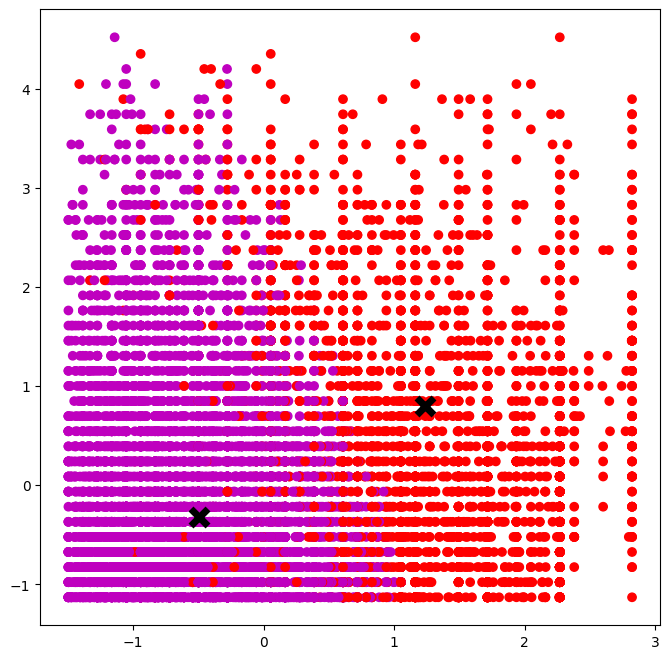

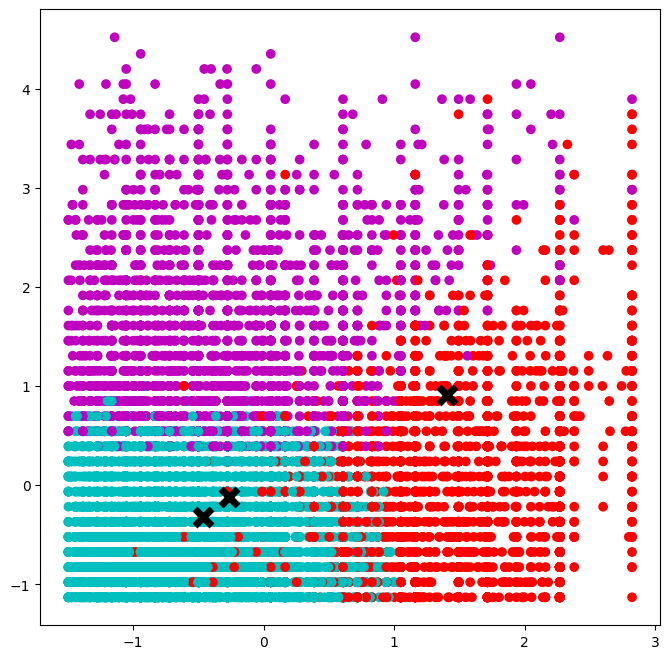

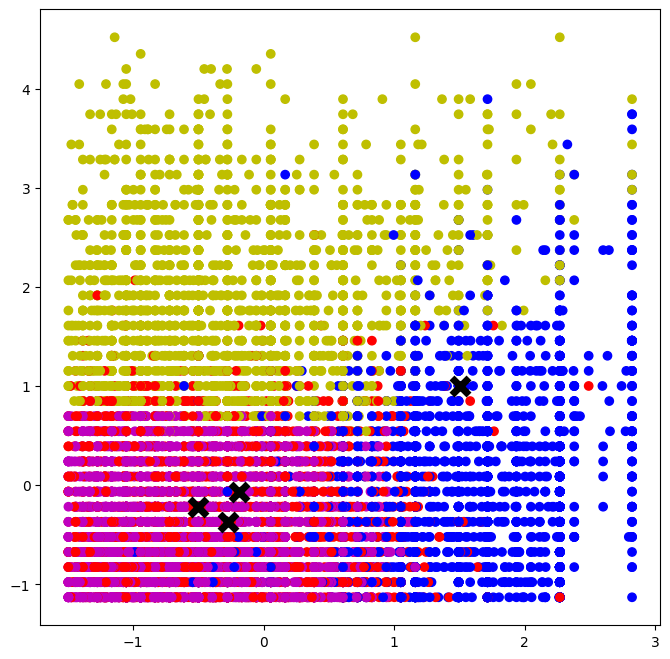

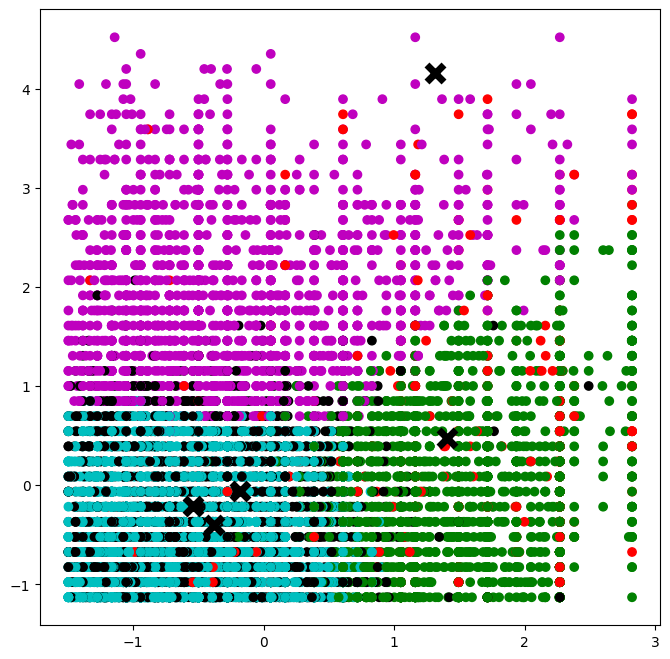

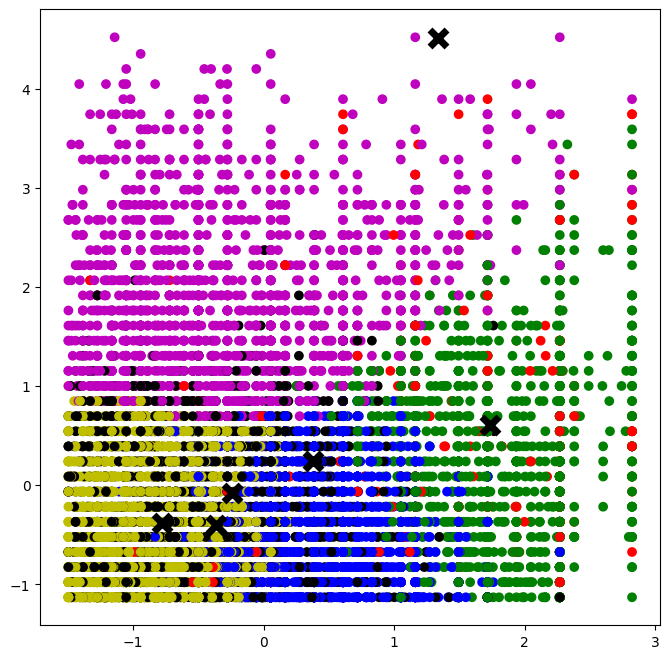

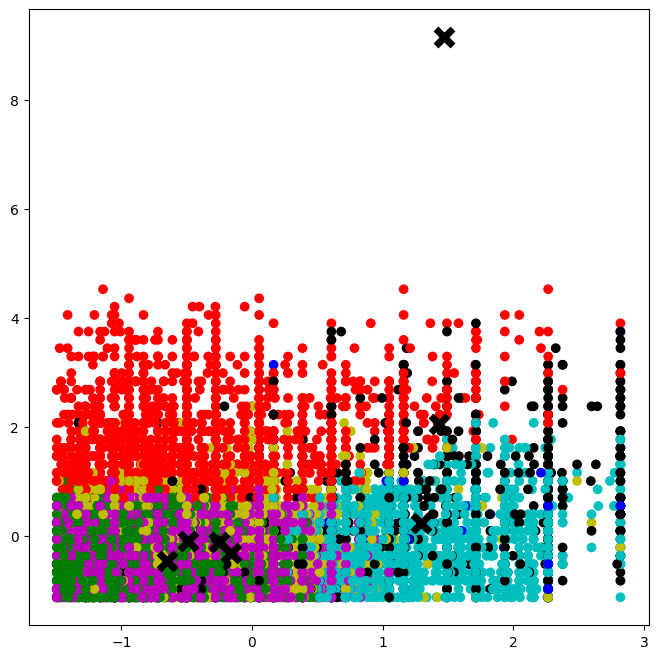

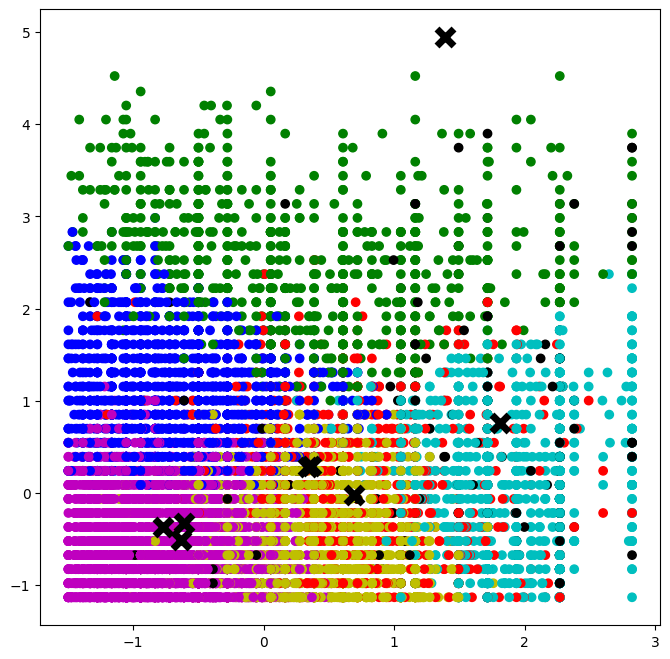

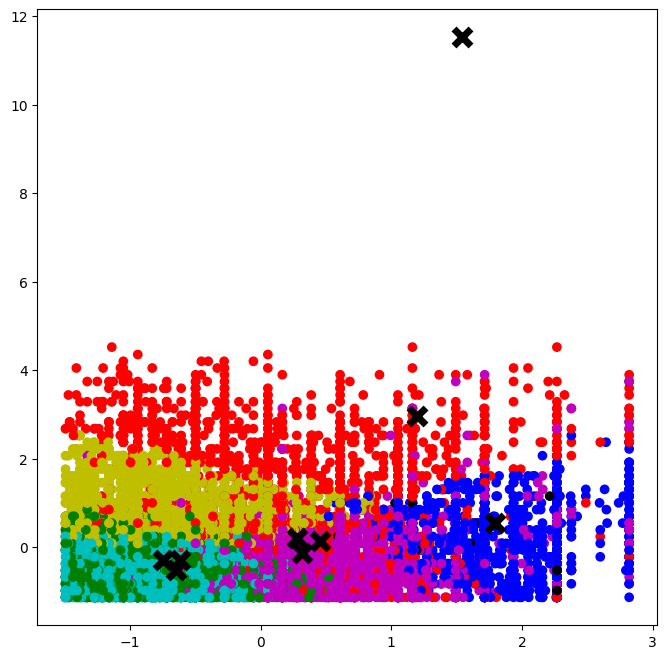

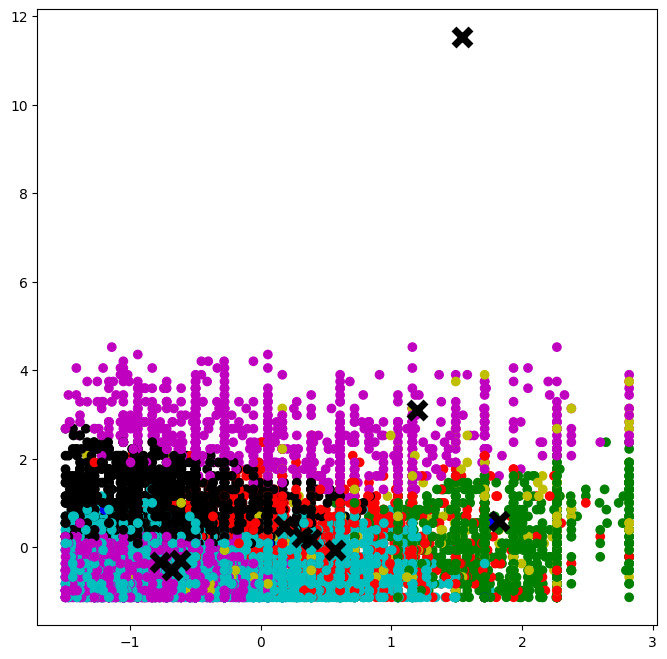

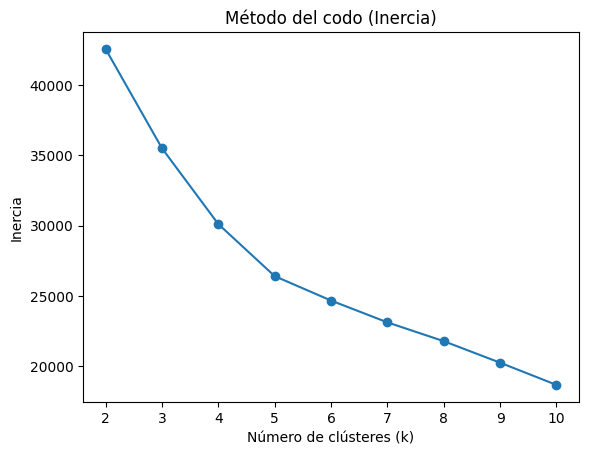

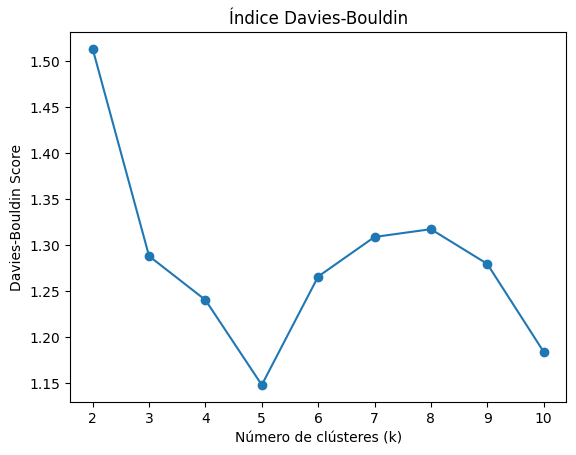

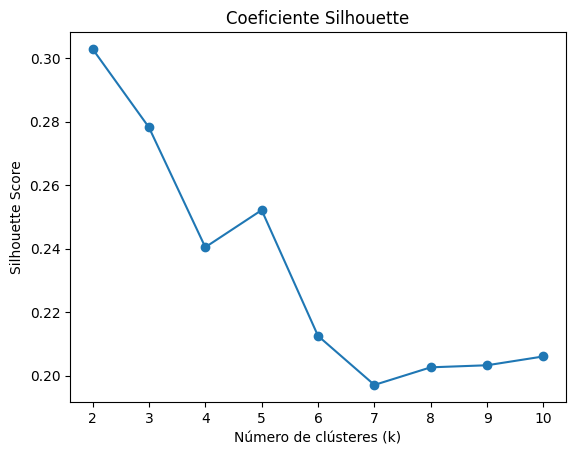

In [41]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA


# Suponemos que X_scaled es el array con todas tus variables escaladas
# (loan_amnt, revenue, dti_n, fico_n) ya preprocesadas.

inertias = []
db_scores = []
sil_scores = []

K_range = range(2, 11)  # desde k=2 hasta k=10

for k in K_range:
    kmeans = KMeans(init='random', n_clusters=k, random_state=333)
    labels = kmeans.fit_predict(X_scaled)
    #kmeans.fit(X_scaled)
    # 1) Inercia (sum of squared distances to centroids)
    inertias.append(kmeans.inertia_)
    
    # 2) Davies-Bouldin (más bajo es mejor)
    db = davies_bouldin_score(X_scaled, labels)
    db_scores.append(db)
    
    # 3) Coeficiente Silhouette (más alto es mejor)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)
    plot_clusters(X_scaled, kmeans.labels_, kmeans.cluster_centers_);
    #pca = PCA(n_components=2)
    #X_pca = pca.fit_transform(X_scaled)   # X_scaled con tus 4 variables
    # X_pca[:,0] y X_pca[:,1] serán los ejes principales
    #plot_clusters(X_pca, labels=kmeans.labels_, centers=kmeans.cluster_centers_)

# --- Diagrama del codo (Inercia) ---
plt.plot(K_range, inertias, marker='o')
plt.title("Método del codo (Inercia)")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Inercia")
plt.show()

# --- Davies-Bouldin ---
plt.plot(K_range, db_scores, marker='o')
plt.title("Índice Davies-Bouldin")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Davies-Bouldin Score")
plt.show()

# --- Coeficiente Silhouette ---
plt.plot(K_range, sil_scores, marker='o')
plt.title("Coeficiente Silhouette")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("Silhouette Score")
plt.show()

__Comentarios__: Como podemos observar el mejor valor del número de clusters es k=5. Esto es debido a que en el diagrama de codo es el valor donde la gráfica cambia de tendencia y a partir del cual el aumento de clusters no produce un cambio significativo en la inercia. Por otro lado si nos fijamos en la gráfica del índice de Davies-Bouldin, en el cual cuanto más pequeño el valor obtenido para una partición, mejor, tenemos que para k=5 tenemos el mínimo del índice, lo que de nuevo nos indica que es la mejor elección de número de clusters.
Por último, si ahora nos fijamos en el gráfico del coeficiente de Silhouette, k=5 toma un valor positivo, lo cual nos indica de nuevo que es una buena elección de número de clústeres, pues recordemos que  toma un valor entre 1 y -1, donde valores 
cercanos a 0 indican la existencia de cluster  solapados, valores negativos indica una
asignación incoherente y valores positivos indican particiones buenas.

## 5) Descripción de los clusters

Describe los clusters que has obtenido en el apartado anterior. Si te han salido más de 3 elige 3 de ellos que sean bastante diferentes entre sí.

Para hacerlo estudia sus descriptores estadísticos y dales un sentido dentro del contexto del problema. ¿Qué perfil de préstamos quedan en cada cluster? Según dicho perfil, ¿qué cluster te parece que tendrá una mayor tasa de "default"? Corrobóralo calculando para cada cluster la proporción de préstamos que acabaron en "default".

Pinta el diagrama de dispersión en función de cada par de variables usando colores diferentes para cada cluster. ¿Qué clusters se separan mejor y en función de qué variables? ¿y cuáles se confunden más?

__Cuidado__: para poder interpretar correctamente los datos necesitas que estén en su escala original. Si decidiste escalar los datos, deberás ejecutar k-Means con los datos escalados pero asignar las etiquetas de clusters al conjunto de datos inicial. En este caso es muy sencillo porque el algoritmo no cambia el orden de los datos así que puedes crear directamente una nueva columna en el dataframe original con esas etiquetas. Puede que aparezca un SettingWithCopyWarning por asignar una nueva columna en un dataframe que es una vista de otro dataframe. Puedes ignorar este aviso o puedes hacer una copia del dataframe con `copy` para que no comparta memoria con el otro.

In [45]:
kmeans_final = KMeans(init='random', n_clusters=5, random_state=333)
labels = kmeans_final.fit_predict(X_scaled)
# Si df_csv tiene el MISMO orden de filas que X_scaled
df_csv['cluster'] = labels
df_csv.groupby('cluster')[['loan_amnt','revenue','dti_n','fico_n']].describe().transpose()

cluster                     0              1              2              3  \
loan_amnt count  3.020000e+02    2885.000000    4993.000000    3636.000000   
          mean   2.634793e+04   27173.535529    9633.551973   11048.783003   
          std    8.879728e+03    5808.520592    4757.496822    5500.538588   
          min    2.500000e+03   10550.000000    1000.000000    1000.000000   
          25%    2.000000e+04   22775.000000    6000.000000    6500.000000   
          50%    2.800000e+04   26000.000000   10000.000000   10000.000000   
          75%    3.500000e+04   32000.000000   12800.000000   15000.000000   
          max    4.000000e+04   40000.000000   25000.000000   37000.000000   
revenue   count  3.020000e+02    2885.000000    4993.000000    3636.000000   
          mean   3.149067e+05  106691.865023   67661.096299   57181.593848   
          std    1.701477e+05   36307.364509   31804.466111   25903.146052   
          min    1.890000e+05   25000.000000    8400.000000    7000.000000   
          25%    2.332500e+05   80000.000000   45000.000000   40000.000000   
          50%    2.600000e+05  100000.000000   61000.000000   52000.000000   
          75%    3.237500e+05  130000.000000   84000.000000   70000.000000   
          max    1.650000e+06  230000.000000  221000.000000  332500.000000   
dti_n     count  3.020000e+02    2885.000000    4993.000000    3636.000000   
          mean   1.164467e+01      19.008565      13.002612      28.962453   
          std    7.628159e+00       7.518383       5.027625       9.394541   
          min    1.200000e-01       0.220000       0.000000      19.000000   
          25%    6.577500e+00      13.850000       9.340000      24.150000   
          50%    1.031500e+01      18.870000      13.380000      27.360000   
          75%    1.556750e+01      23.920000      17.130000      31.802500   
          max    7.743000e+01      62.700000      23.530000     190.870000   
fico_n    count  3.020000e+02    2885.000000    4993.000000    3636.000000   
          mean   7.121987e+02     696.126516     683.661326     689.680143   
          std    3.833703e+01      23.692207      17.141733      20.769959   
          min    6.620000e+02     662.000000     662.000000     662.000000   
          25%    6.820000e+02     677.000000     667.000000     672.000000   
          50%    7.070000e+02     692.000000     682.000000     687.000000   
          75%    7.320000e+02     712.000000     697.000000     707.000000   
          max    8.270000e+02     792.000000     727.000000     782.000000   

cluster                      4  
loan_amnt count    1978.000000  
          mean    12889.092518  
          std      7466.126348  
          min      1000.000000  
          25%      7000.000000  
          50%     12000.000000  
          75%     17000.000000  
          max     40000.000000  
revenue   count    1978.000000  
          mean    76463.266471  
          std     36071.419637  
          min      9036.000000  
          25%     50000.000000  
          50%     70000.000000  
          75%     97000.000000  
          max    225000.000000  
dti_n     count    1978.000000  
          mean       15.716678  
          std         7.737271  
          min         0.000000  
          25%         9.972500  
          50%        15.460000  
          75%        20.720000  
          max        45.880000  
fico_n    count    1978.000000  
          mean      757.771739  
          std        26.296601  
          min       717.000000  
          25%       737.000000  
          50%       752.000000  
          75%       772.000000  
          max       847.500000

__Comentarios:__ Tenemos 5 clústeres y vamos a tratar de describir que tipo de préstamos trata de describir cada uno de ellos. Vamos a interpretar 4 de ellos, los 4 primeros clústeres. Asi tenemos:

    Cluster 0: Vemos en sus estadísticos que cuenta con 3020 individuos y describe préstamos de cantidades elevadas (mean de loan_amnt 26.300). Además, es el clúster con mayores ingresos medios y aunque la desviación de los ingresos sea elevada sigue describiendo un rango alto de ingresos. Vemos que es el grupo que menos índice de endeudamiento tiene (mean de dti_n = 11.64) y tiene un índice de solvencia bastante elevado por lo que es muy bueno (mean fico_n = 712). En conclusión, podemos decir que este clúster se corresponde con aquellos individuos que tienen unos ingresos muy elevados, y a pesar de que el préstamo también sea elevado, se equilibran con sus ingresos dando un índice de solvencia bueno.


    Clúster 1: Observamos que este clúster se corresponde con individuos que han pedido también un préstamo elevado (incluso con una media mayor que el grupo anterior) (mean loan_amnt = 27173) y los ingresos siguen siendo bastante elevados aunque significativamente inferiores a los del clúster anterior (mean revenue = 106691). Esto evidencia un índice de endeudamiento mayor que el grupo anterior (mean dti_n = 19) y con ello el índice de solvencia es también menor (mean fico_n = 696). En resumen, podemos describir este grupo de individuos con un perfil de ingresos elevados aunque inferiores a los del grupo anterior, pero su préstamo es significativamente mayor al anterior en comparación con los ingresos, lo que hace que los índices de solvencia y endeudamiento sean peores.


    Clúster 2: De primeras, destaca que se trata del grupo con menores préstamos (mean loan_amnt = ) así como es el segundo grupo con menores ingresos de media, solo después del 3 (mean revenue = ). Respecto a su índice de endudamiento, también tienen el más bajo del os 5 grupos (mean dti_n = ) pero el índice de solvencia es el más bajo de todos (mean fico_n = ). Esto puede deberse a que el índice de endeudamiento de este grupo presenta una desviación típica muy elevada, por lo que individuos extremos provocan grandes variaciones en la media. En resumen, tenemos un perfil con ingresos y préstamos reducidos que probablemente debido a la inclusión de individuos extremos nos da un índice de solvencia que podría considerarse anormal.

    Clúster 3: Observamos primero que se corresponde con el grupo de individuos con los ingresos más bajos (pues tienen unos ingresos de media de 57k dólares) aunque este estadístico tiene una desviación considerablemente elevada. También se puede observar que son individuos que han pedido un préstamos de media relativamente bajo, (el segundo menor de media), pero de igual manera  tiene una desviación grande. En cuanto al índice de endeudamiento vemos que es el grupo con el mayor índice de media mientras que el índice de solvencia es relativamente bueno. En definitiva, podemos decir que se trata de un grupo de población relativamente pobre, aunque es cierto que hay individuos que sobresalen dentro de este grupo, y que además tienen un índice de solvencia bueno.

Después de haber hecho este estudio detallado de estos 4 clústeres podemos concluir que los que, en principio tendrán una mayor probabilidad de impago será el cluster 3, pues tiene un porcentaje de endeudamiento muy elevado y una solvencia mediana. También podría pasar para el 1 pues es el que representa a individuos que mayor cantidad de préstamos piden, pudiendo resultar en impagos.

In [48]:
grouped_default = df_csv.groupby('cluster')['Default'].value_counts(normalize=True)
print(grouped_default)

cluster  Default
0        0          0.831126
         1          0.168874
1        0          0.746274
         1          0.253726
2        0          0.811336
         1          0.188664
3        0          0.704620
         1          0.295380
4        0          0.893832
         1          0.106168
Name: proportion, dtype: float64


Aquí, corroboramos que el grupo 3 y el 1 son los que mayor porcentaje de individuos con default = 1 recogen, con un 29% y un 25% respectivamente.

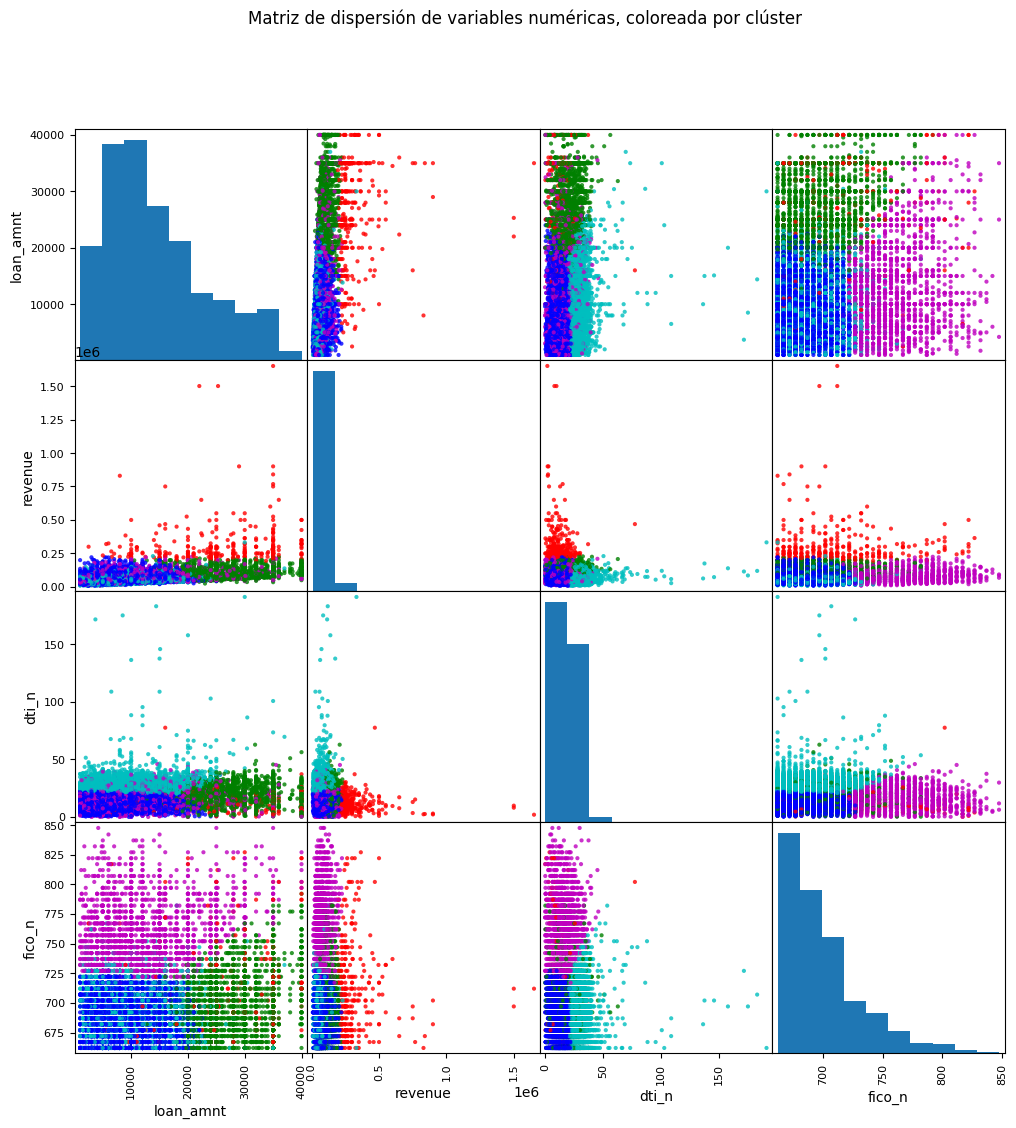

In [53]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# Definimos un diccionario para 5 clusters: 0..4
cluster_colors = {
    0: 'r',  # rojo
    1: 'g',  # verde
    2: 'b',  # azul
    3: 'c',  # cian
    4: 'm',  # magenta
}

# Asignamos los colores mapeando la columna 'cluster'
colors = df_csv['cluster'].map(cluster_colors)

numeric_cols = ['loan_amnt', 'revenue', 'dti_n', 'fico_n']

scatter_matrix(
    df_csv[numeric_cols],
    figsize=(12, 12),
    diagonal='hist',
    c=colors,   # ojo: c=colors, no color=colors
    alpha=0.8
)

plt.suptitle("Matriz de dispersión de variables numéricas, coloreada por clúster")
plt.show()


Observando los grupos más dfierenciados son el azul oscuro y el rojo, que corresponden con los ingresos menos elevados y mas elevados respectivamente y también con el índice de endeudamiento mayor y menor.

En contraposición, los que menos parecen distinguirse son el azul y el cian, debido a que comparten características como ingresos bajos y préstamos solicitados bajos.